In [1]:
import sys
import os

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt 

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../src/construct/')
import util
import annual_heat_demand

idx = pd.IndexSlice

data_path = '../data/'

In [6]:
energy_balances = pd.read_csv('../build/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)
subsectors = pd.read_csv(data_path + '/energy_balance_category_names.csv', index_col=0)
carriers = pd.read_csv(data_path + '/energy_balance_carrier_names.csv', index_col=0)
JRC_IDEES =  pd.read_csv(data_path + 'commercial/JRC_IDEES_commercial_end_use_consumption.csv', index_col=[0, 1, 2, 3, 4], squeeze=True, header=0)
JRC_IDEES = (
    JRC_IDEES
    .rename(util.get_alpha3, level='country_code')
    .xs('ktoe', level='unit')
    .apply(util.ktoe_to_twh)
#    .groupby(level=0, axis=1).sum()
#    .stack()
)
published_data = pd.read_csv(data_path + 'commercial/published_commercial_end_use_consumption.csv', index_col=[0, 1, 2, 3, 4], squeeze=True, header=0)

In [7]:
_carriers = {
    'H8000': 'heat', 
    'RA600': 'ambient_heat',
    'R5110-5150_W6000RI': 'biofuel',
    'R5160': 'biofuel',
    'R5300': 'gas',
    'W6210': 'biofuel',
    'R5210P': 'oil',
    'R5210B': 'oil',
    'R5220P': 'oil',
    'R5220B': 'oil',
    '5230P': 'oil',
    'R5230B': 'oil',
    'R5290': 'oil',
    'RA100': 'renewable_heat',
    'RA500': 'renewable_heat',
    'RA300': 'renewable_heat',
    'RA420': 'renewable_heat',
    'RA410': 'renewable_heat',
    'RA200': 'renewable_heat',
    'E7000': 'electricity', 
    'C0350-0370': 'gas', 
    'G3000': 'gas',
    'O4000XBIO': 'oil', 
    'P1000': 'solid_fossil', 
    'S2000': 'oil', 
    'N900H': 'heat',
    'C0000X0350-0370': 'solid_fossil', 
    'W6100_6220': 'biofuel'
}

countries = {i: util.get_alpha3(i) for i in energy_balances.index.levels[3]}
years = {i: int(i) for i in range(2000, 2019)}

commercial_energy_balances = (
    energy_balances.xs('FC_OTH_CP_E')
    .apply(util.tj_to_twh)
    .groupby(
        [countries, years, _carriers],
        level=['country', 'year', 'carrier_code']
    ).sum()
    .rename_axis(index=['country_code', 'year', 'carrier_name'])
    .reorder_levels(['carrier_name', 'country_code', 'year'])
)

In [8]:
JRC_IDEES_percent = JRC_IDEES.div(JRC_IDEES.sum(level=['carrier_name', 'country_code', 'year'])).unstack('year').dropna(how='all')
JRC_IDEES_percent = JRC_IDEES_percent.assign(**{str(i): JRC_IDEES_percent.mean(axis=1) for i in range(2016,2019)})
JRC_IDEES_percent.columns = JRC_IDEES_percent.columns.astype(int)
JRC_IDEES_percent_by_country = JRC_IDEES_percent.stack('year').unstack('country_code')
balkan_countries = JRC_IDEES_percent_by_country[['BGR', 'HRV', 'HUN', 'ROU', 'GRC']].mean(axis=1)
nordic_countries = JRC_IDEES_percent_by_country[['SWE', 'FIN', 'DNK']].mean(axis=1)
JRC_IDEES_percent_by_country = JRC_IDEES_percent_by_country.assign(
    ALB=balkan_countries,
    BIH=balkan_countries,
    MNE=balkan_countries,
    MKD=balkan_countries,
    SRB=balkan_countries,   
    NOR=nordic_countries,
    ISL=nordic_countries
)

mapped_end_uses = (
    JRC_IDEES_percent_by_country.stack()
    .align(commercial_energy_balances)[1]
    .mul(JRC_IDEES_percent_by_country.stack())
    .dropna()
)
mapped_end_uses.index = mapped_end_uses.index.remove_unused_levels()
mapped_end_uses = mapped_end_uses.sort_index()

In [9]:
commercial_energy_balances#.index.get_level_values('year').unique().difference(JRC_IDEES.index.get_level_values('year').unique())

carrier_name    country_code  year  
ambient_heat    ALB           2000.0     0.000000
biofuel         ALB           2000.0     0.450000
electricity     ALB           2000.0     0.625000
gas             ALB           2000.0     0.000000
heat            ALB           2000.0     0.000000
                                          ...    
gas             SWE           2018.0     0.933000
heat            SWE           2018.0    14.943056
oil             SWE           2018.0     3.286808
renewable_heat  SWE           2018.0     0.000000
solid_fossil    SWE           2018.0     0.000000
Name: 0, Length: 5130, dtype: float64

In [29]:
CH_end_use_electricity = (
    published_data
    .xs(('CH', 'commercial', 'electricity'))
    .sum(level='year')
    .to_frame('CHE')
    .rename_axis(columns='country_code')
    .stack()
    .reorder_levels(['country_code', 'year'])
)
CH_end_use_demand = (
    published_data
    .xs(('CH', 'commercial'))
    .sum(level=['year', 'end_use'])
    .unstack('end_use')
    .rename(columns={'other': 'end_use_electricity', 'space_cooling': 'end_use_electricity'})
    .groupby(level=0, axis=1).sum()
    .stack()
    .to_frame('CHE')
    .rename_axis(columns='country_code')
    .stack()
    .reorder_levels(['country_code', 'year', 'end_use'])
)

In [72]:
mapped_end_use_demand = mapped_end_uses.sum(level=['country_code', 'year', 'end_use']).append(CH_end_use_demand).sort_index()
mapped_end_use_electricity = (
    mapped_end_uses
    .sum(level=['country_code', 'year', 'end_use'])
    .xs('end_use_electricity', level='end_use').add(       
        mapped_end_uses
        .drop('end_use_electricity', level='end_use')
        .sum(level=['country_code', 'year', 'carrier_name'])
        .xs('electricity', level='carrier_name')
    )
    .append(CH_end_use_electricity)
    .sort_index()
)

# fill gaps
mapped_end_use_demand = (
    mapped_end_use_demand
    .unstack(['country_code', 'end_use'])
    .fillna(
        mapped_end_use_demand
        .groupby(['country_code', 'end_use'])
        .agg('first')
    )
    .stack([0, 1])
)
mapped_end_use_electricity = (
    mapped_end_use_electricity.unstack('country_code')
    .fillna(mapped_end_use_electricity.groupby('country_code').agg('first'))
    .stack()
)

 

In [54]:
mapped_end_use_electricity = (
    mapped_end_uses
    .sum(level=['country_code', 'year', 'end_use'])
    .xs('end_use_electricity', level='end_use').add(       
        mapped_end_uses
        .drop('end_use_electricity', level='end_use')
        .sum(level=['country_code', 'year', 'carrier_name'])
        .xs('electricity', level='carrier_name')
    )
    .append(CH_end_use_electricity)
    .sort_index()
)

# Regionalise to Euro-Calliope regions

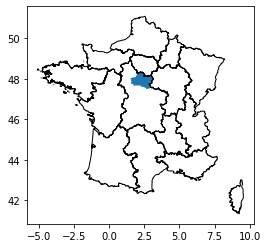

In [210]:
ax = missing_ids.loc[['FRB06']].plot()
eurospores_units[eurospores_units.country_code == 'FRA'].plot(ax=ax, fc='None', ec='black')

In [287]:
len(eurospores_units.country_code.unique())

35

In [218]:
# Get regions
eurospores_units = gpd.read_file('../build/units.geojson')

eurospores_to_nuts3 = pd.read_excel('../data/eurospores.xlsx', sheet_name='locations', index_col='NUTS3')

nuts3_2016 = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2016_4326_LEVL_3.geojson')

nuts3_2016 = nuts3_2016[
    (nuts3_2016.bounds.minx >= eurospores_units.total_bounds[0]) &
    (nuts3_2016.bounds.miny >= eurospores_units.total_bounds[1]) &
    (nuts3_2016.bounds.maxx <= eurospores_units.total_bounds[2]) &
    (nuts3_2016.bounds.maxy <= eurospores_units.total_bounds[3]) &
    nuts3_2016.CNTR_CODE.isin(countries.keys())
]

nuts3_valid_in_both = (
    nuts3_2016
    .set_index('id')
    .reindex(eurospores_to_nuts3.index)
    .assign(eurospores=eurospores_to_nuts3.EuroSPORES)
    .dropna()
    ['eurospores']
)

missing_ids = nuts3_2016[~nuts3_2016.id.isin(eurospores_to_nuts3.index.dropna())].set_index('id').to_crs('epsg:3035')
eurospores_m = eurospores_units.to_crs('epsg:3035')
for i in missing_ids.index:
    country = util.get_alpha3(missing_ids.loc[i, 'CNTR_CODE'])
    try:
        location = gpd.overlay(
            missing_ids.loc[[i]], eurospores_m[eurospores_m.country_code == country]
        )
        if len(location) > 1:
            location['area'] = location.area / location.area.sum()
            print('Choosing {} with {}% of {} area'.format(location.sort_values('area').iloc[0].id, location['area'].max() * 100, i))
            nuts3_valid_in_both[i] = location.sort_values('area').iloc[0].id
        else:
            nuts3_valid_in_both[i] = location.id.item()
    except ValueError:
        print(f'skipping {i} entirely')

nuts3_2016_eurospores = (
    nuts3_2016
    .set_index('id')
    .loc[nuts3_valid_in_both.index]
    .assign(eurospores=nuts3_valid_in_both.values)
)
# One specific instance where the data doesn't match and we hardcode the nuts region
nuts3_2016_eurospores.index = nuts3_2016_eurospores.index.str.replace('NO060', 'NO06')

       COAST_TYPE  MOUNT_TYPE CNTR_CODE    FID NUTS_ID             NUTS_NAME  \
id                                                                             
ES531           1           4        ES  ES531   ES531  Eivissa y Formentera   

       LEVL_CODE  URBN_TYPE                                           geometry  
id                                                                              
ES531          3          2  MULTIPOLYGON (((3586664.969 1821646.877, 35863...  
       COAST_TYPE  MOUNT_TYPE CNTR_CODE    FID NUTS_ID NUTS_NAME  LEVL_CODE  \
id                                                                            
ES532           1           4        ES  ES532   ES532  Mallorca          3   

       URBN_TYPE                                           geometry  
id                                                                   
ES532          1  MULTIPOLYGON (((3735722.088 1899591.075, 37359...  
       COAST_TYPE  MOUNT_TYPE CNTR_CODE    FID NUTS_ID NUTS_NAME  LE

In [273]:
eurospores_units.country_code.apply(util.get_alpha2).str.find('EL').max()

0

In [274]:
eurospores_units = gpd.read_file('../build/units.geojson')

eurospores_to_nuts3 = pd.read_excel('../data/eurospores.xlsx', sheet_name='locations', index_col='NUTS3')
eurospores_to_nuts3 = eurospores_to_nuts3[eurospores_to_nuts3.Source == 'NUTS3']
nuts3_2010 = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2010_4326_LEVL_3.geojson')
nuts3_2010 = nuts3_2010[nuts3_2010.CNTR_CODE.isin(eurospores_units.country_code.apply(util.get_alpha2))]

In [275]:
gpd.overlay(nuts3_2010, eurospores_units)

,id_1,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,id_2,country_code,name,type,proper,geometry
0,AT111,AT,Mittelburgenland,3,AT111,AT111,AUT_3,AUT,eurospores_cluster,eurospores_cluster,True,"POLYGON ((16.64622 47.44660, 16.63850 47.44600..."
1,AT112,AT,Nordburgenland,3,AT112,AT112,AUT_3,AUT,eurospores_cluster,eurospores_cluster,True,"POLYGON ((17.16080 48.00666, 17.15428 48.00355..."
2,AT113,AT,Südburgenland,3,AT113,AT113,AUT_3,AUT,eurospores_cluster,eurospores_cluster,True,"POLYGON ((16.43371 47.35282, 16.43600 47.35150..."
3,AT121,AT,Mostviertel-Eisenwurzen,3,AT121,AT121,AUT_3,AUT,eurospores_cluster,eurospores_cluster,True,"POLYGON ((15.50768 48.31960, 15.51012 48.31049..."
4,AT122,AT,Niederösterreich-Süd,3,AT122,AT122,AUT_3,AUT,eurospores_cluster,eurospores_cluster,True,"POLYGON ((15.91586 48.08854, 15.91606 48.08483..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1561,UKM61,UK,Caithness & Sutherland and Ross & Cromarty,3,UKM61,UKM61,GBR_5,GBR,eurospores_cluster,eurospores_cluster,True,"MULTIPOLYGON (((-4.43155 57.49428, -4.44280 57..."
1562,UKM62,UK,"Inverness & Nairn and Moray, Badenoch & Strath...",3,UKM62,UKM62,GBR_5,GBR,eurospores_cluster,eurospores_cluster,True,"POLYGON ((-2.80151 57.69525, -2.80257 57.67413..."
1563,UKM63,UK,"Lochaber, Skye & Lochalsh, Arran & Cumbrae and...",3,UKM63,UKM63,GBR_5,GBR,eurospores_cluster,eurospores_cluster,True,"MULTIPOLYGON (((-4.53214 56.79591, -4.53525 56..."
1564,UKM64,UK,Eilean Siar (Western Isles),3,UKM64,UKM64,GBR_5,GBR,eurospores_cluster,eurospores_cluster,True,"MULTIPOLYGON (((-5.84001 59.11607, -5.84121 59..."


In [264]:
# Get regions
eurospores_units = gpd.read_file('../build/units.geojson')

eurospores_to_nuts3 = pd.read_excel('../data/eurospores.xlsx', sheet_name='locations', index_col='NUTS3')
eurospores_to_nuts3 = eurospores_to_nuts3[eurospores_to_nuts3.Source == 'NUTS3']
nuts3_2010 = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2010_4326_LEVL_3.geojson')

nuts3_2010 = nuts3_2010[nuts3_2010.CNTR_CODE.isin(eurospores_units.country_code.apply(util.get_alpha2))]
nuts3_2010 = gpd.overlay(nuts3_2010, eurospores_units)
nuts3_valid_in_both = (
    nuts3_2010
    .set_index('id')
    .reindex(eurospores_to_nuts3.index)
    .assign(eurospores=eurospores_to_nuts3.EuroSPORES)
    .dropna()
    ['eurospores']
)

missing_ids = nuts3_2010[~nuts3_2010.id.isin(eurospores_to_nuts3.index.dropna())].set_index('id').to_crs('epsg:3035')
eurospores_m = eurospores_units.to_crs('epsg:3035')
for i in missing_ids.index:
    country = util.get_alpha3(missing_ids.loc[i, 'CNTR_CODE'])
    try:
        location = gpd.overlay(
            missing_ids.loc[[i]], eurospores_m[eurospores_m.country_code == country]
        )
        if len(location) > 1:
            location['area'] = location.area / location.area.sum()
            print('Choosing {} with {}% of {} area'.format(location.sort_values('area').iloc[0].id, location['area'].max() * 100, i))
            nuts3_valid_in_both[i] = location.sort_values('area').iloc[0].id
        else:
            nuts3_valid_in_both[i] = location.id.item()
    except ValueError:
        print(f'skipping {i} entirely')

nuts3_2010_eurospores = (
    nuts3_2010
    .set_index('id')
    .loc[nuts3_valid_in_both.index]
    .assign(eurospores=nuts3_valid_in_both.values)
)
# One specific instance where the data doesn't match and we hardcode the nuts region
#nuts3_2010_eurospores.index = nuts3_2010_eurospores.index.str.replace('NO060', 'NO06')

skipping EL211 entirely
skipping EL212 entirely
skipping EL221 entirely
skipping EL222 entirely
skipping EL223 entirely
skipping EL224 entirely
skipping EL411 entirely
skipping EL412 entirely
skipping EL413 entirely
skipping EL421 entirely
skipping EL422 entirely
skipping EL431 entirely
skipping EL432 entirely
skipping EL433 entirely
skipping EL434 entirely
skipping ES531 entirely
skipping ES532 entirely
skipping ES533 entirely
skipping ES630 entirely
skipping ES640 entirely
skipping HR031 entirely
skipping HR034 entirely
skipping IE013 entirely
skipping ITH59 entirely
skipping LT00A entirely
skipping NL113 entirely


In [281]:
nuts3_valid_in_both

NUTS3
AT322    AUT_1
AT342    AUT_1
AT323    AUT_1
AT335    AUT_1
AT321    AUT_1
         ...  
UKG37    GBR_3
UKG38    GBR_3
UKG39    GBR_3
UKH24    GBR_1
UKH25    GBR_1
Name: eurospores, Length: 1330, dtype: object

In [219]:
# Base regionalisation on GVA
gva_df = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nama_10r_3gva.tsv.gz', delimiter='\t', index_col=0)
gva_df.index = gva_df.index.str.split(',', expand=True).rename(['unit', 'cat_name', 'region'])
gva_df.columns = gva_df.columns.astype(int)
gva_df = gva_df.apply(util.to_numeric)
gva_eu = gva_df.xs('MIO_EUR').loc[['G-J', 'K-N', 'O-U']].sum(level='region', min_count=1).reindex(nuts3_2016_eurospores.index).rename_axis(index='nuts3')
gva_eu = gva_eu.set_index([nuts3_2016_eurospores.eurospores, nuts3_2016_eurospores.CNTR_CODE], append=True)
#gva_intensity = gva_eu.div(gva_eu.sum())

In [2]:
ch_gva_excel = 'https://www.bfs.admin.ch/bfsstatic/dam/assets/10647597/master'
ch_gva_dfs = []
for canton in pd.ExcelFile(ch_gva_excel).sheet_names:
    ch_gva = pd.read_excel(ch_gva_excel, sheet_name=canton, index_col=0, skiprows=3, skipfooter=16, usecols='A,C:L')
    ch_gva_dfs.append(ch_gva.loc[['GHIJ', 'K', 'LMNRS', 'O', 'T']].sum())
ch_gva_df = pd.concat(ch_gva_dfs, names=['canton'], keys=pd.ExcelFile(ch_gva_excel).sheet_names)

In [3]:
ch_gva_df = pd.concat(ch_gva_dfs, names=['canton'], keys=pd.ExcelFile(ch_gva_excel).sheet_names).unstack()

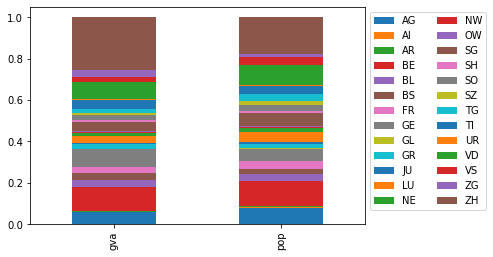

In [98]:
# Quick check that population wouldn't just be fine
ch_pop = pd.Series({
    'ZH': 1520968,
    'BE': 1034977,
    'LU': 409557,
    'UR': 36433,
    'SZ': 159165,
    'OW': 37841,
    'NW': 43223,
    'GL': 40403,
    'ZG': 126837,
    'FR': 318714,
    'SO': 273194,
    'BS': 200298,
    'BL': 290765,
    'SH': 81991,
    'AR': 55234,
    'AI': 16145,
    'SG': 507697,
    'GR': 198379,
    'AG': 678207,
    'TG': 276472,
    'TI': 353343,
    'VD': 799145,
    'VS': 343955,
    'NE': 176850,
    'GE': 499480,
    'JU': 73419
})
ax = pd.concat([ch_gva_df.unstack().div(ch_gva_df.sum(level=1))['2017p'], ch_pop.div(ch_pop.sum())], axis=1, keys=['gva', 'pop'], sort=True).T.plot.bar(stacked=True)
ax.legend(ncol=2, bbox_to_anchor=(1, 1))
# Result suggests we should perservere with GVA

In [107]:
ch_canton_to_nuts3 = {
    'AG': 'CH033',
    'AI': 'CH054',
    'AR': 'CH053',
    'BE': 'CH021',
    'BL': 'CH032',
    'BS': 'CH031',
    'FR': 'CH022',
    'GE': 'CH013',
    'GL': 'CH051',
    'GR': 'CH056',
    'JU': 'CH025',
    'LU': 'CH061',
    'NE': 'CH024',
    'NW': 'CH065',
    'OW': 'CH064',
    'SG': 'CH055',
    'SH': 'CH052',
    'SO': 'CH023',
    'SZ': 'CH063',
    'TG': 'CH057',
    'TI': 'CH070',
    'UR': 'CH062',
    'VD': 'CH011',
    'VS': 'CH012',
    'ZG': 'CH066',
    'ZH': 'CH040'
}
ch_gva_df.index = ch_gva_df.index.map(ch_canton_to_nuts3).rename()
ch_gva_df.columns = util.to_numeric(ch_gva_df.columns.astype(str)).rename('year')

In [220]:
gva_eu.loc[idx[ch_gva_df.index, :, :], ch_gva_df.columns] = ch_gva_df.values

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2867: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [221]:
gva_intensity = gva_eu.sum(level=['eurospores', 'CNTR_CODE'], min_count=1).div(gva_eu.sum(level='CNTR_CODE', min_count=1)).droplevel('CNTR_CODE')

In [231]:
gva_intensity = gva_intensity.reindex(eurospores_units.set_index('id').index)
gva_intensity[eurospores_units.set_index('id')['type'] == 'country'] = 1
gva_intensity = gva_intensity.T.fillna(gva_intensity.mean(axis=1)).T
gva_eurospores_units = eurospores_units.merge(gva_intensity, left_on='id', right_index=True)

(2441393.3718154863, 6720297.174706739, 1184351.0717050442, 5617488.491273391)

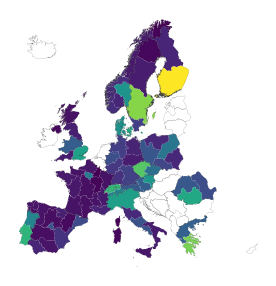

In [236]:
ax = gva_eurospores_units[gva_eurospores_units['type'] != 'country'].to_crs('epsg:3035').plot(2017, figsize=(5, 5), vmin=0, vmax=1)
gva_eurospores_units.to_crs('epsg:3035').dissolve('country_code').simplify(10000).plot(ax=ax, fc='None', ec='black', lw=0.1)
ax.axis('off')
fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.15, 0.05, 0.6, 0.02])
fig.colorbar(mappable=ax[0, 0].collections[0], cax=cbar_ax, orientation='horizontal')

In [237]:
pop_df = pd.read_csv('../build/population.csv')

In [239]:
foo = gva_eurospores_units.merge(pop_df, left_on='id', right_on='id')
foo['population'] = foo.set_index(['id', 'country_code']).population_sum.div(foo.groupby('country_code').sum().population_sum).values

(2441393.3718154863, 6720297.174706739, 1184351.0717050442, 5617488.491273391)

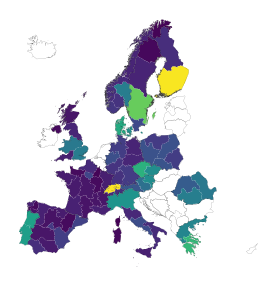

In [243]:
ax = foo[foo['type'] != 'country'].to_crs('epsg:3035').plot('population', figsize=(5, 5))
gva_eurospores_units.to_crs('epsg:3035').dissolve('country_code').simplify(10000).plot(ax=ax, fc='None', ec='black', lw=0.1)
ax.axis('off')